In [ ]:
# this is the original proposed model for predicting hospital re-admissions

# Get requirement.txt for Submission

In [82]:
#get requirement.txt file
!pip freeze > requirement.txt

In [6]:
#check python version
from platform import python_version
print(python_version())

3.7.6


# Install required Packages and Libraries 

In [7]:
!pip install xgboost
from xgboost import XGBClassifier
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer # lemmatizes word based on its parts of speech
from sklearn.metrics import roc_curve, classification_report, confusion_matrix 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the Datasets

In [8]:
#load ADMISSIONS dataset
admissions_data = pd.read_csv(r'C:\Users\pankt\Final_Year\ADMISSIONS.csv')


# Prepare Data

In [9]:
# Exploring data in admissions table
admissions_data.shape

(58976, 19)

In [10]:
# to explore categories of ADMISSION_TYPE column
admissions_data['ADMISSION_TYPE'].value_counts()

EMERGENCY    42071
NEWBORN       7863
ELECTIVE      7706
URGENT        1336
Name: ADMISSION_TYPE, dtype: int64

In [11]:
# Remove New Born admissions from dataset
admissions_data = admissions_data.loc[admissions_data.ADMISSION_TYPE != 'NEWBORN']

In [12]:
# to explore categories of ADMISSION_TYPE column, to make sure NEWBORN is removed
admissions_data['ADMISSION_TYPE'].value_counts()

EMERGENCY    42071
ELECTIVE      7706
URGENT        1336
Name: ADMISSION_TYPE, dtype: int64

In [13]:
#to remove death admissions
hadm_rows_death = admissions_data.loc[admissions_data.DEATHTIME.notnull()]
print("Total Admissions Died:", len(hadm_rows_death))

# store hadm_id for dead patients in a list, to remove deaths admissions from NOTEEVENTS data 
hadm_death_list = list(hadm_rows_death["HADM_ID"])

print("HADM_ID List Total:", len(hadm_death_list))

Total Admissions Died: 5792
HADM_ID List Total: 5792


In [14]:
#remove death admissions
admissions_data = admissions_data.loc[admissions_data.DEATHTIME.isnull()]

In [15]:
# to ensure rows with specific deathtime are removed

print('Shape of Admissions Table:', admissions_data.shape)
print('Total Number of Admissions Alive:', admissions_data.DEATHTIME.isnull().count())


Shape of Admissions Table: (45321, 19)
Total Number of Admissions Alive: 45321


In [16]:
#convert date strings format to datetime format 
admissions_data.ADMITTIME = pd.to_datetime(admissions_data.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admissions_data.DISCHTIME = pd.to_datetime(admissions_data.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admissions_data.DEATHTIME = pd.to_datetime(admissions_data.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

#to count and check null dates fields
print('Total NULL Admissions Dates:', admissions_data.ADMITTIME.isnull().count())
print('Total NULL Discharge Dates:', admissions_data.DISCHTIME.isnull().count())

Total NULL Admissions Dates: 45321
Total NULL Discharge Dates: 45321


In [17]:
#to sort values according to subject_id and admittime
admissions_data = admissions_data.sort_values(['SUBJECT_ID','ADMITTIME'])
#drop is added to prevent old index used as column
#new sequential index is used by resetting the index
admissions_data = admissions_data.reset_index(drop = True)

In [18]:
#create next_admittime and next_admission type columns to calculate number of days gap between 2 admits
admissions_data['NEXT_ADMITTIME'] = admissions_data.groupby('SUBJECT_ID').ADMITTIME.shift(-1)

admissions_data['NEXT_ADMISSION_TYPE'] = admissions_data.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [19]:
#remove entries with next admission type as elective
#as we are considering only urgent and emergency next admit type to calculate readmissions
rows = admissions_data.NEXT_ADMISSION_TYPE == 'ELECTIVE'
admissions_data.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
admissions_data.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

In [20]:
#again sort values according to subject id and admittime
admissions_data = admissions_data.sort_values(['SUBJECT_ID','ADMITTIME'])
# back fill data
admissions_data[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = admissions_data.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [21]:
# calculate days between 2 consecutive admits
admissions_data['DAYS_BETWEEN_ADMITS'] = (admissions_data.NEXT_ADMITTIME - admissions_data.DISCHTIME).dt.total_seconds()/(24*60*60) 

In [22]:
#print HADM_ID list
len(list(admissions_data['HADM_ID']))

45321

In [23]:
#to count admissions category in next_admission_type column
admissions_data['NEXT_ADMISSION_TYPE'].value_counts()

EMERGENCY    9561
URGENT        144
Name: NEXT_ADMISSION_TYPE, dtype: int64

In [24]:
#count data in next_admission_type column
admissions_data['NEXT_ADMISSION_TYPE'].count()

9705

In [25]:
#to check count of null values under days_till_next_admit column
pd.isnull(admissions_data.DAYS_BETWEEN_ADMITS).value_counts()

True     35616
False     9705
Name: DAYS_BETWEEN_ADMITS, dtype: int64

In [26]:
#load NOTEEVENTS.csv
noteevents_data = pd.read_csv("NOTEEVENTS.csv")

C:\Users\pankt\anaconda_3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
#to check the lists where HADM_ID is null
sum(list(noteevents_data.HADM_ID.isnull()))

231836

In [28]:
#exploring noteevents dataset
noteevents_data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [29]:
#to check with hadm_id list and remove death admissions 
noteevents_data = noteevents_data[~noteevents_data['HADM_ID'].isin(hadm_death_list)]
# print noteevents data after removing deaths
noteevents_data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [30]:
# print shape of noteevents data after deaths are removed
print('shape of data after deaths removed:', noteevents_data.shape)

shape of data after deaths removed: (1841968, 11)


In [31]:
#convert string format to date format
noteevents_data.CHARTDATE = pd.to_datetime(noteevents_data.CHARTDATE, format = '%Y-%m-%d', errors = 'coerce')

noteevents_data.CHARTTIME = pd.to_datetime(noteevents_data.CHARTTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [32]:
# sort values and provide new index to noteevents data
noteevents_data = noteevents_data.sort_values(['SUBJECT_ID','CHARTDATE', 'CHARTTIME'])
noteevents_data = noteevents_data.reset_index(drop = True)

In [33]:
# explore noteevents data after removing unwanted columns
noteevents_data[['SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME', 'TEXT']].head()

,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,TEXT
0,2,163353.0,2138-07-17,2138-07-17 22:51:00,Neonatology Attending Triage Note\n\nBaby [**N...
1,2,163353.0,2138-07-17,2138-07-17 23:08:00,Nursing Transfer note\n\n\nPt admitted to NICU...
2,3,NaN,2101-10-06,2101-10-06 18:02:00,[**2101-10-6**] 6:02 PM\n CHEST (PORTABLE AP) ...
3,3,NaN,2101-10-06,NaT,Sinus rhythm\nInferior/lateral ST-T changes ar...
4,3,NaN,2101-10-11,2101-10-11 21:06:00,[**2101-10-11**] 9:06 PM\n CHEST (PRE-OP PA & ...


In [34]:
# filter the data for DISHCHARGE SUMMARIES for further prediction
notes_discharge_summary = noteevents_data.loc[noteevents_data.CATEGORY == 'Discharge summary']

In [35]:
# consider only one admission entry per HADM_ID
notes_discharge_summary_unique = (notes_discharge_summary.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
assert notes_discharge_summary_unique.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

# Merge ADMISSIONS and NOTEEVENTS datasets

In [36]:
# merge 2 datasets and prepare data for further steps 
adm_notes_data = pd.merge(admissions_data[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_BETWEEN_ADMITS','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],
                        notes_discharge_summary_unique[['SUBJECT_ID','HADM_ID','TEXT']], 
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')
assert len(admissions_data) == len(adm_notes_data), 'Number of rows increased'

In [37]:
#groupby the data according to admission_type column
adm_notes_data.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/adm_notes_data.groupby('ADMISSION_TYPE').size()

ADMISSION_TYPE
ELECTIVE     0.048076
EMERGENCY    0.028550
URGENT       0.028936
dtype: float64

In [38]:
# showcase the merged dataset
print(adm_notes_data.head())

   SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
0           3   145834 2101-10-20 19:08:00 2101-10-31 13:58:00   
1           4   185777 2191-03-16 00:28:00 2191-03-23 18:41:00   
2           6   107064 2175-05-30 07:15:00 2175-06-15 16:00:00   
3          11   194540 2178-04-16 06:18:00 2178-05-11 19:00:00   
4          13   143045 2167-01-08 18:43:00 2167-01-15 15:15:00   

   DAYS_BETWEEN_ADMITS NEXT_ADMITTIME ADMISSION_TYPE DEATHTIME  \
0                  NaN            NaT      EMERGENCY       NaT   
1                  NaN            NaT      EMERGENCY       NaT   
2                  NaN            NaT       ELECTIVE       NaT   
3                  NaN            NaT      EMERGENCY       NaT   
4                  NaN            NaT      EMERGENCY       NaT   

                                                TEXT  
0  Admission Date:  [**2101-10-20**]     Discharg...  
1  Admission Date:  [**2191-3-16**]     Discharge...  
2  Admission Date: [**2175-5-30**]       

In [39]:
# explore the merged dataset
adm_notes_data.shape

(45321, 9)

In [40]:
# check if all the entries under DEATHTIME column is NULL
adm_notes_data['DEATHTIME']

0       NaT
1       NaT
2       NaT
3       NaT
4       NaT
         ..
45316   NaT
45317   NaT
45318   NaT
45319   NaT
45320   NaT
Name: DEATHTIME, Length: 45321, dtype: datetime64[ns]

In [41]:
# drop unwanted deathtime column
adm_notes_data.drop('DEATHTIME',inplace=True, axis=1)

In [42]:
# dimensions of merged dataset
adm_notes_data.shape

(45321, 8)

In [43]:
# remove OUTPUT_LABEL for further breaking of dataset
adm_notes_data.iloc[:,:-1]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_BETWEEN_ADMITS,NEXT_ADMITTIME,ADMISSION_TYPE
0,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,NaT,EMERGENCY
1,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,NaT,EMERGENCY
2,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,NaT,ELECTIVE
3,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaN,NaT,EMERGENCY
4,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaN,NaT,EMERGENCY
...,...,...,...,...,...,...,...
45316,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,NaN,NaT,EMERGENCY
45317,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00,NaN,NaT,ELECTIVE
45318,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,NaN,NaT,EMERGENCY
45319,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,NaN,NaT,ELECTIVE


In [44]:
# create output_label based on readmissions done within 30 days of discharge
adm_notes_data['OUTPUT_LABEL'] = (adm_notes_data.DAYS_BETWEEN_ADMITS < 30).astype('int')

In [45]:
# to check how many readmissions were under 30 days, 1 represents readmissions were under 30 days
print(adm_notes_data['OUTPUT_LABEL'].value_counts())

0    42772
1     2549
Name: OUTPUT_LABEL, dtype: int64


In [46]:
# to evaluate number of samples with positive and negative labels 
print('Number of positive samples:', (adm_notes_data.OUTPUT_LABEL == 1).sum())
print('Number of negative samples:',  (adm_notes_data.OUTPUT_LABEL == 0).sum())
print('Total samples:', len(adm_notes_data))

Number of positive samples: 2549
Number of negative samples: 42772
Total samples: 45321


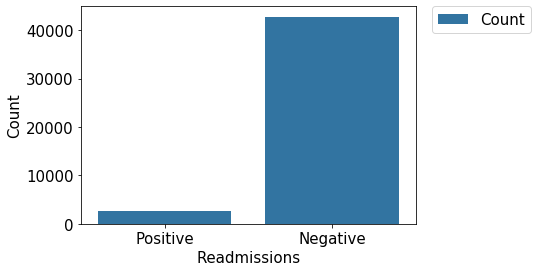

In [47]:
# compare base models 
df_results_data = pd.DataFrame({'Number of Readmissions':['Positive',
                                         'Negative'],
                        
                           'data_set':['Count', 'Count'],
                
                          'Count':[(adm_notes_data.OUTPUT_LABEL == 1).sum(),
                                      (adm_notes_data.OUTPUT_LABEL == 0).sum(),]
                          })

# showcase results in form of table
df_results_data

#create a histogram of the output
ax = sns.barplot(x="Number of Readmissions", y="Count",hue = "data_set", data=df_results_data)
ax.set_xlabel('Readmissions',fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

# Shuffle the Samples and Split Dataset into Train and Test Set

In [48]:
# break down the merged dataset into X and y 
X = adm_notes_data.iloc[:,:-1]
y = adm_notes_data['OUTPUT_LABEL']

In [49]:
#shuffle the samples 
adm_notes_data = adm_notes_data.sample(n = len(adm_notes_data), random_state = 72)
adm_notes_data = adm_notes_data.reset_index(drop = True)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [50]:
# explore dimensions of X and y data
print("X:" ,X.head())
print("Y:" ,y.head())
print("X: " , X.shape)
print("Y: ", y.shape)

X:    SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
0           3   145834 2101-10-20 19:08:00 2101-10-31 13:58:00   
1           4   185777 2191-03-16 00:28:00 2191-03-23 18:41:00   
2           6   107064 2175-05-30 07:15:00 2175-06-15 16:00:00   
3          11   194540 2178-04-16 06:18:00 2178-05-11 19:00:00   
4          13   143045 2167-01-08 18:43:00 2167-01-15 15:15:00   

   DAYS_BETWEEN_ADMITS NEXT_ADMITTIME ADMISSION_TYPE  \
0                  NaN            NaT      EMERGENCY   
1                  NaN            NaT      EMERGENCY   
2                  NaN            NaT       ELECTIVE   
3                  NaN            NaT      EMERGENCY   
4                  NaN            NaT      EMERGENCY   

                                                TEXT  
0  Admission Date:  [**2101-10-20**]     Discharg...  
1  Admission Date:  [**2191-3-16**]     Discharge...  
2  Admission Date: [**2175-5-30**]        Dischar...  
3  Admission Date:  [**2178-4-16**]        

In [51]:
# resample the data to avoid overfitting 
sampl_temp = pd.concat([X_train,y_train],axis=1)

# as the positive samples are much lesser than the negative samples
# we need to downsample the majority i.e. negative samples
# to avoid over fitting in the prediction output
# Separate majority and minority classes
df_majority = sampl_temp[sampl_temp.OUTPUT_LABEL==0]
df_minority = sampl_temp[sampl_temp.OUTPUT_LABEL==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=1805,     # to match minority class
                                 random_state=72) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.OUTPUT_LABEL.value_counts()

1    1821
0    1805
Name: OUTPUT_LABEL, dtype: int64

In [52]:
# explore training data
print((sampl_temp.OUTPUT_LABEL == 1).sum())
print((sampl_temp.OUTPUT_LABEL == 0).sum())

1821
29903


In [53]:
# explore the downsampled data dimensions
print(df_downsampled.shape)
print(type(df_downsampled))
print(df_downsampled.head())

(3626, 9)
<class 'pandas.core.frame.DataFrame'>
       SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
31990       53534   143092 2186-01-30 22:03:00 2186-02-09 17:40:00   
39040       78005   110094 2195-09-11 07:15:00 2195-09-21 13:25:00   
3729         4427   177640 2124-03-07 07:15:00 2124-03-10 12:48:00   
30959       50148   175147 2147-11-23 12:55:00 2147-11-26 13:30:00   
11273       13171   165021 2107-06-27 05:50:00 2107-07-08 14:30:00   

       DAYS_BETWEEN_ADMITS NEXT_ADMITTIME ADMISSION_TYPE  \
31990                  NaN            NaT      EMERGENCY   
39040                  NaN            NaT       ELECTIVE   
3729                   NaN            NaT       ELECTIVE   
30959                  NaN            NaT      EMERGENCY   
11273                  NaN            NaT      EMERGENCY   

                                                    TEXT  OUTPUT_LABEL  
31990  Admission Date:  [**2186-1-30**]              ...             0  
39040  Admission Date:  

# Preprocess the Textual Data

In [54]:
# POS Tagging is to assign words with respective Tags
def convert_tag(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

In [55]:
# lemmatize the tokens to convert words into its basic meaningful word
def lemmatizer(tokens):
    tagged_words = pos_tag(tokens)
    wnl = WordNetLemmatizer()
    
    lemma_words = []
    for tupl in tagged_words:
        lemma_words.append(wnl.lemmatize(tupl[0], convert_tag(tupl[1])))
    
    return lemma_words

In [56]:
# clean and tokenize the words by removing numbers, puntuations, stop words and by converting words to lower case

def preprocessing(text):
    
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\r', '', text)
    word_tokens = word_tokenize(text) 
    tokens = [word for word in word_tokens if word not in stopwords.words('english')]
    lemmatized_tokens = lemmatizer(tokens)
    return lemmatized_tokens

# Feature Extraction

In [57]:
# Implement Count Vectorizer to Training Data

vectorized_text = CountVectorizer(max_features=10000, tokenizer=preprocessing)
vectorized_text.fit(df_downsampled.TEXT.values.astype(str))

C:\Users\pankt\anaconda_3\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function preprocessing at 0x0000022221E14E58>,
                vocabulary=None)

In [58]:
# creating testing data
temp_test = pd.concat([X_test,y_test],axis=1)

In [59]:
# explore test data
print(type(temp_test))
print(temp_test.shape)
print(temp_test.head())

<class 'pandas.core.frame.DataFrame'>
(13597, 9)
       SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
37748       73661   154150 2118-02-22 19:34:00 2118-03-01 17:45:00   
22843       26868   144208 2163-03-23 14:37:00 2163-04-05 17:15:00   
39030       77960   140473 2196-08-03 14:00:00 2196-08-09 15:56:00   
28368       40973   149259 2177-07-17 20:44:00 2177-07-19 15:30:00   
8274         9725   165189 2151-10-23 22:00:00 2151-11-02 19:30:00   

       DAYS_BETWEEN_ADMITS      NEXT_ADMITTIME ADMISSION_TYPE  \
37748                  NaN                 NaT      EMERGENCY   
22843              54.3625 2163-05-30 01:57:00      EMERGENCY   
39030                  NaN                 NaT       ELECTIVE   
28368                  NaN                 NaT      EMERGENCY   
8274                   NaN                 NaT      EMERGENCY   

                                                    TEXT  OUTPUT_LABEL  
37748  Admission Date:  [**2118-2-22**]              ...          

In [60]:
# print positive and negative labels in test data
print(temp_test.OUTPUT_LABEL.value_counts())

0    12869
1      728
Name: OUTPUT_LABEL, dtype: int64


In [61]:
# to transform the data into vector format
X_train_tf = vectorized_text.transform(df_downsampled.TEXT.values.astype(str))
X_test_tf = vectorized_text.transform(temp_test.TEXT.values.astype(str))

In [62]:
# provide output labels to test and train data
y_train_tf = df_downsampled.OUTPUT_LABEL
y_test_tf = temp_test.OUTPUT_LABEL

# Define Evaluation Metrics

In [63]:
# print evaluation metrics
def showResults(modelname,test, pred):
    accuracy = accuracy_score(test, pred)
    precision=precision_score(test, pred, average='weighted')
    f1Score=f1_score(test, pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("F1Score : {}".format(f1Score))
    print("Confusion Matrix: ")
    print(confusion_matrix(test, pred))
    print("Classification Report: ")
    print(classification_report(test, pred))
    results = accuracy
    return results

# Implementation of Machine Learning Models

# Implementing the K-Nearest Neighbors Model


Base KNN Model Performance:
Accuracy  : 0.8362874163418401
Precision : 0.9072704627041888
F1Score : 0.8682396931642266
Confusion Matrix: 
[[11193  1676]
 [  550   178]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     12869
           1       0.10      0.24      0.14       728

    accuracy                           0.84     13597
   macro avg       0.52      0.56      0.52     13597
weighted avg       0.91      0.84      0.87     13597

Grid KNN Model Performance:
Accuracy  : 0.8345958667353093
Precision : 0.907313014747954
F1Score : 0.8672659336655654
Confusion Matrix: 
[[11168  1701]
 [  548   180]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     12869
           1       0.10      0.25      0.14       728

    accuracy                           0.83     13597
   macro avg       0.52      0.56      0.52     13597
weighted avg    

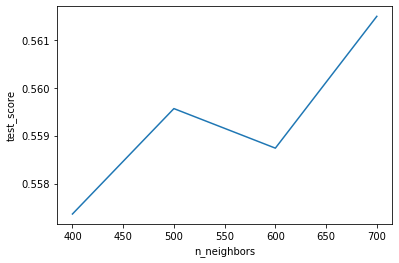

In [64]:
# implement basic KNN clasifier

temp_knn = KNeighborsClassifier(n_neighbors=500)
temp_knn.fit(X_train_tf, y_train_tf)

base_knn_predictions=temp_knn.predict(X_test_tf)
print("Base KNN Model Performance:")
knn_base_results = showResults("Base KNN",y_test_tf, base_knn_predictions)

# print cross validation score
#scores = cross_val_score(temp_knn, X_train_tf, y_train_tf, cv=5, scoring='accuracy')
#print(np.mean(scores))

#apply grid search CV on KNN model 
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors": [400, 500, 600, 700]}
#use gridsearch to test all values for n_neighbors
grid_knn = GridSearchCV(temp_knn, param_grid, cv=3)
#fit model to data
grid_knn.fit(X_train_tf, y_train_tf)

grid_knn_predictions=grid_knn.predict(X_test_tf)
print("Grid KNN Model Performance:")
grid_knn_results = showResults("GridSearchCV KNN",y_test_tf, grid_knn_predictions)

# print chart to evaluate neighbours and test score
grid_knn_scores_df = pd.DataFrame(grid_knn.cv_results_['params'])
grid_knn_scores_df['test_score'] = grid_knn.cv_results_['mean_test_score']
ax = sns.lineplot(x="n_neighbors", y="test_score", data=grid_knn_scores_df)
figure=ax.get_figure()

# print cross validation score of gridsearch knn model
#scores = cross_val_score(grid_knn, X_train_tf, y_train_tf, cv=10, scoring='accuracy')
#print(np.mean(scores))

In [65]:
# to print comparitive results of KNN model
print("Base KNN Model\n")
showResults("Base KNN",y_test_tf, base_knn_predictions)

print("\nGridSearchCV KNN Model\n")
grid_knn_results = showResults("GridSearchCV KNN",y_test_tf, grid_knn_predictions)

Base KNN Model

Accuracy  : 0.8362874163418401
Precision : 0.9072704627041888
F1Score : 0.8682396931642266
Confusion Matrix: 
[[11193  1676]
 [  550   178]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     12869
           1       0.10      0.24      0.14       728

    accuracy                           0.84     13597
   macro avg       0.52      0.56      0.52     13597
weighted avg       0.91      0.84      0.87     13597


GridSearchCV KNN Model

Accuracy  : 0.8345958667353093
Precision : 0.907313014747954
F1Score : 0.8672659336655654
Confusion Matrix: 
[[11168  1701]
 [  548   180]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     12869
           1       0.10      0.25      0.14       728

    accuracy                           0.83     13597
   macro avg       0.52      0.56      0.52     13597
weighted avg       0.91      0.

# Implementing the Random Forest Classifier

In [66]:
# evaluate RF classifier 
base_rf = RandomForestClassifier(n_estimators = 20, random_state = 42,max_depth=100, max_features="auto")
base_rf.fit(X_train_tf, y_train_tf)


base_rf_predictions=base_rf.predict(X_test_tf)
#print(base_rf_predictions.shape)

base_rf_results = showResults("Base RF",y_test_tf, base_rf_predictions)

#scores = cross_val_score(base_rf, X_train_tf, y_train_tf, cv=10, scoring='accuracy')
#print("Mean Cross-validation score = ", np.mean(scores))

# to implement Random Search CV on RF model
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]# number of features at every split
max_features = ["auto", "sqrt"]

# max depth
max_depth = [int(x) for x in np.linspace(20, 300, num = 10)]
max_depth.append(None)

# create random grid
random_grid = {
 "n_estimators": n_estimators,
 "max_features": max_features,
 "max_depth": max_depth}

# Random search of parameters
random_rf = RandomizedSearchCV(estimator = base_rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the model
random_rf.fit(X_train_tf, y_train_tf)

# print results
print("Best Parameters are")
print(random_rf.best_params_)
print("Best Score is")
print(random_rf.best_score_)

best_random=random_rf.best_estimator_
random_rf_predictions = best_random.predict(X_test_tf)

Accuracy  : 0.6399205707141281
Precision : 0.9164537741355766
F1Score : 0.7383699922574766
Confusion Matrix: 
[[8286 4583]
 [ 313  415]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.64      0.77     12869
           1       0.08      0.57      0.14       728

    accuracy                           0.64     13597
   macro avg       0.52      0.61      0.46     13597
weighted avg       0.92      0.64      0.74     13597

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 12.1min finished


Best Parameters are
{'n_estimators': 560, 'max_features': 'sqrt', 'max_depth': 175}
Best Score is
0.6343093191790051


In [67]:
# provide comparitive results of RF models
print("Base Random Forest Model\n")
showResults("Base RF",y_test_tf, base_rf_predictions)

print("\nRandomSearchCV Model\n")
random_rf_results = showResults("RandomSearchCV RF",y_test_tf, random_rf_predictions)


Base Random Forest Model

Accuracy  : 0.6399205707141281
Precision : 0.9164537741355766
F1Score : 0.7383699922574766
Confusion Matrix: 
[[8286 4583]
 [ 313  415]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.64      0.77     12869
           1       0.08      0.57      0.14       728

    accuracy                           0.64     13597
   macro avg       0.52      0.61      0.46     13597
weighted avg       0.92      0.64      0.74     13597


RandomSearchCV Model

Accuracy  : 0.5948370964183276
Precision : 0.9212986623603648
F1Score : 0.7028016936409185
Confusion Matrix: 
[[7606 5263]
 [ 246  482]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.59      0.73     12869
           1       0.08      0.66      0.15       728

    accuracy                           0.59     13597
   macro avg       0.53      0.63      0.44     13597
weighted avg       0.92      0

# Implementing the Logistic Regression Model

In [68]:
# to implement LR model
lr=LogisticRegression(random_state = 72)
lr.fit(X_train_tf, y_train_tf)

base_lr_predictions=lr.predict(X_test_tf)

base_lr_results = showResults("Base LR",y_test_tf, base_lr_predictions)

# to implement Grid Search CV model 

#create a dictionary of all values we want to test for n_neighbors
param_grid = { 'C': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    'penalty': ['l2'],
    'n_jobs': [-1]}
#use gridsearch to test all values for n_neighbors
grid_lr = GridSearchCV(lr, param_grid, cv=3)
#fit model to data
grid_lr.fit(X_train_tf, y_train_tf)
print("Best Parameters are")
print(grid_lr.best_params_)
print("Best Score is")
print(grid_lr.best_score_)

best_grid_lr=grid_lr.best_estimator_
grid_lr_predictions = best_grid_lr.predict(X_test_tf)
print(grid_lr_predictions.shape)

grid_lr_results = showResults("GridSearchCV LR",y_test_tf, grid_lr_predictions)

C:\Users\pankt\anaconda_3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy  : 0.6060160329484445
Precision : 0.9143582241626724
F1Score : 0.7122687644407134
Confusion Matrix: 
[[7823 5046]
 [ 311  417]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.61      0.74     12869
           1       0.08      0.57      0.13       728

    accuracy                           0.61     13597
   macro avg       0.52      0.59      0.44     13597
weighted avg       0.91      0.61      0.71     13597

Best Parameters are
{'C': 0.0001, 'n_jobs': -1, 'penalty': 'l2'}
Best Score is
0.6169357121076838
(13597,)
Accuracy  : 0.6780172096786056
Precision : 0.9181810654194031
F1Score : 0.7665250399099057
Confusion Matrix: 
[[8811 4058]
 [ 320  408]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     12869
           1       0.09      0.56      0.16       728

    accuracy                           0.68     13597
   macro avg       0.53   

In [69]:
# comparitive results of LR model 

print("Base LR Model\n")
showResults("Base LR",y_test_tf, base_lr_predictions)
print("GridSearchCV LR Model\n")

showResults("GridSearchCV LR",y_test_tf, grid_lr_predictions)

Base LR Model

Accuracy  : 0.6060160329484445
Precision : 0.9143582241626724
F1Score : 0.7122687644407134
Confusion Matrix: 
[[7823 5046]
 [ 311  417]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.61      0.74     12869
           1       0.08      0.57      0.13       728

    accuracy                           0.61     13597
   macro avg       0.52      0.59      0.44     13597
weighted avg       0.91      0.61      0.71     13597

GridSearchCV LR Model

Accuracy  : 0.6780172096786056
Precision : 0.9181810654194031
F1Score : 0.7665250399099057
Confusion Matrix: 
[[8811 4058]
 [ 320  408]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     12869
           1       0.09      0.56      0.16       728

    accuracy                           0.68     13597
   macro avg       0.53      0.62      0.48     13597
weighted avg       0.92      0.68      0.

0.6780172096786056

# Implementing the Stochastic Gradient Descend Model

In [70]:
# impleemnt SGDC classifier
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 72)
sgdc.fit(X_train_tf, y_train_tf)

base_sgdc_predictions=sgdc.predict(X_test_tf)
sgdc_base_results = showResults("Base SGDC",y_test_tf, base_sgdc_predictions)

#implement Random CV on base SGDC model 

penalty = ['none','l2','l1']
max_iter = range(1000,5000,10000)
alpha = [0.001,0.003,0.01,0.03,0.1,0.3]
random_grid_sgdc = {'penalty':penalty,
              'max_iter':max_iter,
              'alpha':alpha}
# create the randomized search cross-validation
sgdc_random = RandomizedSearchCV(estimator = sgdc, param_distributions = random_grid_sgdc, 
                                 n_iter = 1000, cv = 2,verbose = 0, 
                                 random_state = 72)

sgdc_random.fit(X_train_tf, y_train_tf)

random_sgdc_predictions = sgdc_random.predict(X_test_tf)

sgdc_random_results = showResults("RandomSearchCV SGDC",y_test_tf, random_sgdc_predictions)

#implement Grid Search CV on base SGDC model 
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]}
#use gridsearch to test all values for n_neighbors
grid_sgdc = GridSearchCV(sgdc, param_grid, cv=3)
#fit model to data
grid_sgdc.fit(X_train_tf, y_train_tf)
print("Best Parameters are")
print(grid_sgdc.best_params_)
print("Best Score is")
print(grid_sgdc.best_score_)

best_grid_sgdc=grid_sgdc.best_estimator_
grid_sgdc_predictions = best_grid_sgdc.predict(X_test_tf)
print(grid_sgdc_predictions.shape)
sgdc_grid_results = showResults("GridSearchCV SGDC",y_test_tf, grid_sgdc_predictions)


Accuracy  : 0.6761785688019416
Precision : 0.9177437590372003
F1Score : 0.7651935042895893
Confusion Matrix: 
[[8789 4080]
 [ 323  405]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     12869
           1       0.09      0.56      0.16       728

    accuracy                           0.68     13597
   macro avg       0.53      0.62      0.48     13597
weighted avg       0.92      0.68      0.77     13597



C:\Users\pankt\anaconda_3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 18 is smaller than n_iter=1000. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\pankt\anaconda_3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Accuracy  : 0.726630874457601
Precision : 0.9185413167485799
F1Score : 0.8006925264428532
Confusion Matrix: 
[[9499 3370]
 [ 347  381]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     12869
           1       0.10      0.52      0.17       728

    accuracy                           0.73     13597
   macro avg       0.53      0.63      0.50     13597
weighted avg       0.92      0.73      0.80     13597

Best Parameters are
{'alpha': 1.0, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}
Best Score is
0.6067266837935499
(13597,)
Accuracy  : 0.5643892035007723
Precision : 0.9194724600603003
F1Score : 0.6778830239303024
Confusion Matrix: 
[[7191 5678]
 [ 245  483]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.56      0.71     12869
           1       0.08      0.66      0.14       728

    accuracy                           0.56     13597
   macro av

In [71]:
# showcase results of SGDC models
print("Base SGDC Model\n")
showResults("Base SGDC",y_test_tf, base_rf_predictions)

print("\nRandomSearchSGDC Model\n")
showResults("nRandomSearchSGDC",y_test_tf, random_sgdc_predictions)

print("\nGridSearchSGDC Model\n")
showResults("GridSearchCV_SGDC",y_test_tf, grid_sgdc_predictions)

Base SGDC Model

Accuracy  : 0.6399205707141281
Precision : 0.9164537741355766
F1Score : 0.7383699922574766
Confusion Matrix: 
[[8286 4583]
 [ 313  415]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.64      0.77     12869
           1       0.08      0.57      0.14       728

    accuracy                           0.64     13597
   macro avg       0.52      0.61      0.46     13597
weighted avg       0.92      0.64      0.74     13597


RandomSearchSGDC Model

Accuracy  : 0.726630874457601
Precision : 0.9185413167485799
F1Score : 0.8006925264428532
Confusion Matrix: 
[[9499 3370]
 [ 347  381]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     12869
           1       0.10      0.52      0.17       728

    accuracy                           0.73     13597
   macro avg       0.53      0.63      0.50     13597
weighted avg       0.92      0.73     

0.5643892035007723

# Implementing the Decision Tree Classifier

In [72]:
# implement Decision Tree Classifier
tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train_tf, y_train_tf)

base_tree_predictions = tree.predict(X_test_tf)
tree_base_results = showResults("Base Decision Tree",y_test_tf, base_tree_predictions)

Accuracy  : 0.7169963962638818
Precision : 0.9104614149092509
F1Score : 0.793612891289752
Confusion Matrix: 
[[9442 3427]
 [ 421  307]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     12869
           1       0.08      0.42      0.14       728

    accuracy                           0.72     13597
   macro avg       0.52      0.58      0.48     13597
weighted avg       0.91      0.72      0.79     13597



# Implementing the Gradient Boosting Classifier Model

In [73]:
#implement GBC
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train_tf)

base_gbc_predictions=gbc.predict(X_test_tf)
gbc_base_results = showResults("Base GBC",y_test_tf, base_gbc_predictions)


#apply randomsearchCV on GBC

n_estimators = range(100,500,100)

# maximum depth of the tree
max_depth = range(1,5,1)

# learning rate
learning_rate = [0.001,0.01,0.1]

# random grid

random_grid_gbc = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'learning_rate':learning_rate}

# create the randomized search cross-validation
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid_gbc,
                                n_iter = 20, cv = 2, 
                                verbose = 0, random_state = 42)

gbc_random.fit(X_train_tf, y_train_tf)

random_gbc_predictions = gbc_random.predict(X_test_tf)

gbc_random_results = showResults("RandomSearchCV GBC",y_test_tf, random_gbc_predictions)

# apply grid search cv on gbc

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'learning_rate':[0.01, 0.05, 0.1, 0.5, 1], 
              'min_samples_split':[2,5,10,20], 
              'max_depth':[2,3,5,10]}
#use gridsearch to test all values for n_neighbors
grid_gbc = GridSearchCV(gbc, param_grid, cv=3)
#fit model to data
grid_gbc.fit(X_train_tf, y_train_tf)
print("Best Parameters are")
print(grid_gbc.best_params_)
print("Best Score is")
print(grid_gbc.best_score_)

best_grid_gbc=grid_gbc.best_estimator_
grid_gbc_predictions = best_grid_gbc.predict(X_test_tf)
#print(grid_gbc_predictions.shape)
gbc_grid_results = showResults("GridSearchCV GBC",y_test_tf, grid_gbc_predictions)

Accuracy  : 0.6152827829668309
Precision : 0.9113680846215375
F1Score : 0.7197173814137172
Confusion Matrix: 
[[7981 4888]
 [ 343  385]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.62      0.75     12869
           1       0.07      0.53      0.13       728

    accuracy                           0.62     13597
   macro avg       0.52      0.57      0.44     13597
weighted avg       0.91      0.62      0.72     13597

Accuracy  : 0.642274031036258
Precision : 0.916167731570519
F1Score : 0.7401588489864933
Confusion Matrix: 
[[8322 4547]
 [ 317  411]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.65      0.77     12869
           1       0.08      0.56      0.14       728

    accuracy                           0.64     13597
   macro avg       0.52      0.61      0.46     13597
weighted avg       0.92      0.64      0.74     13597

Best Parameters are
{'lear

In [74]:
# showcase comparitive results of gbc model
print("Base GBC Model\n")
showResults("Base GBC",y_test_tf, random_gbc_predictions)

print("\nRandomSearch_GBC Model\n")
showResults("GridSearchCV_SGDC",y_test_tf, grid_gbc_predictions)

print("\nRandomSearch_GBC Model\n")
showResults("GridSearchCV GBC",y_test_tf, grid_gbc_predictions)

Base GBC Model

Accuracy  : 0.642274031036258
Precision : 0.916167731570519
F1Score : 0.7401588489864933
Confusion Matrix: 
[[8322 4547]
 [ 317  411]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.65      0.77     12869
           1       0.08      0.56      0.14       728

    accuracy                           0.64     13597
   macro avg       0.52      0.61      0.46     13597
weighted avg       0.92      0.64      0.74     13597


RandomSearch_GBC Model

Accuracy  : 0.6160182393174966
Precision : 0.9185074750083366
F1Score : 0.7198605981410122
Confusion Matrix: 
[[7929 4940]
 [ 281  447]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.62      0.75     12869
           1       0.08      0.61      0.15       728

    accuracy                           0.62     13597
   macro avg       0.52      0.62      0.45     13597
weighted avg       0.92      0.62      0

0.6160182393174966

# Implementing the ADA Boost Classifier Model

In [75]:
# implement ADA algorithm
adaclass = AdaBoostClassifier(n_estimators = 20, learning_rate = 0.2, random_state = 42)
adaclass.fit(X_train_tf, y_train_tf)

base_ada_predictions=adaclass.predict(X_test_tf)
ada_base_results = showResults("Base ADA",y_test_tf, base_ada_predictions)

# implement grid search CV
ada_boost = AdaBoostClassifier(n_estimators = 20, learning_rate = 0.2, random_state = 42)
gridparam = {
    'n_estimators':[100,200,500],
    'learning_rate':[0.2,0.5,1.0],
},
adagrid = GridSearchCV(ada_boost, cv = 3, n_jobs = 3, param_grid=gridparam)
adagrid. fit(X_train_tf, y_train_tf)

grid_ada_predictions=adagrid.predict(X_test_tf)
ada_grid_results = showResults("GridSearchCV ADA",y_test_tf, grid_ada_predictions)

Accuracy  : 0.6386702949179967
Precision : 0.9155934093433475
F1Score : 0.7374553384540836
Confusion Matrix: 
[[8276 4593]
 [ 320  408]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.64      0.77     12869
           1       0.08      0.56      0.14       728

    accuracy                           0.64     13597
   macro avg       0.52      0.60      0.46     13597
weighted avg       0.92      0.64      0.74     13597

Accuracy  : 0.6802235787306024
Precision : 0.9185347231527079
F1Score : 0.7681202279667153
Confusion Matrix: 
[[8839 4030]
 [ 318  410]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.69      0.80     12869
           1       0.09      0.56      0.16       728

    accuracy                           0.68     13597
   macro avg       0.53      0.63      0.48     13597
weighted avg       0.92      0.68      0.77     13597



In [76]:
# compare results of ADA models
print("Base ADABOOST Model\n")
showResults("Base ADA",y_test_tf, base_ada_predictions)

print("\nRandomSearch_ADA Model\n")
showResults("GridSearchCV ADA",y_test_tf, grid_ada_predictions)

Base ADABOOST Model

Accuracy  : 0.6386702949179967
Precision : 0.9155934093433475
F1Score : 0.7374553384540836
Confusion Matrix: 
[[8276 4593]
 [ 320  408]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.64      0.77     12869
           1       0.08      0.56      0.14       728

    accuracy                           0.64     13597
   macro avg       0.52      0.60      0.46     13597
weighted avg       0.92      0.64      0.74     13597


RandomSearch_ADA Model

Accuracy  : 0.6802235787306024
Precision : 0.9185347231527079
F1Score : 0.7681202279667153
Confusion Matrix: 
[[8839 4030]
 [ 318  410]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.69      0.80     12869
           1       0.09      0.56      0.16       728

    accuracy                           0.68     13597
   macro avg       0.53      0.63      0.48     13597
weighted avg       0.92      0.68

0.6802235787306024

# Implementing the XG Boost Classifier Model

In [77]:
# implement XG boost classifier 
xgb = XGBClassifier(
    n_estimators=200, 
    max_depth=5,
    learning_rate=.1,
    colsample_bytree=.7,
    #random_state=seed,
    gpu_id=0,
    tree_method="gpu_hist"
)

xgb.fit(X_train_tf, y_train_tf)

base_XGB_predictions=xgb.predict(X_test_tf)
xgb_base_results = showResults("Base XGB",y_test_tf, base_XGB_predictions)

# implement grid search CV with XGB classifier

gridparam = {
    'n_estimators':[100,200,500],
    'learning_rate':[0.2,0.5,1.0],
},
xgb_grid = GridSearchCV(xgb, cv = 3, n_jobs = 3, param_grid=gridparam)
xgb_grid. fit(X_train_tf, y_train_tf)

xgb_grid.best_params_
grid_XGB_predictions = xgb_grid.predict(X_test_tf)
xgb_grid_results = showResults("Grid XGB",y_test_tf, grid_XGB_predictions)

Accuracy  : 0.6445539457233214
Precision : 0.917756239875888
F1Score : 0.7418242848262075
Confusion Matrix: 
[[8340 4529]
 [ 304  424]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.65      0.78     12869
           1       0.09      0.58      0.15       728

    accuracy                           0.64     13597
   macro avg       0.53      0.62      0.46     13597
weighted avg       0.92      0.64      0.74     13597



C:\Users\pankt\anaconda_3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Accuracy  : 0.6438184893726557
Precision : 0.9188189134049036
F1Score : 0.7412323196629254
Confusion Matrix: 
[[8320 4549]
 [ 294  434]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.65      0.77     12869
           1       0.09      0.60      0.15       728

    accuracy                           0.64     13597
   macro avg       0.53      0.62      0.46     13597
weighted avg       0.92      0.64      0.74     13597



In [78]:
# showcase results of XGB models

print("Base XGB Model\n")
showResults("Base XGB",y_test_tf, base_XGB_predictions)

print("\nGridSearch XGB Model\n")
showResults("Grid XGB",y_test_tf, grid_XGB_predictions)

Base XGB Model

Accuracy  : 0.6445539457233214
Precision : 0.917756239875888
F1Score : 0.7418242848262075
Confusion Matrix: 
[[8340 4529]
 [ 304  424]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.65      0.78     12869
           1       0.09      0.58      0.15       728

    accuracy                           0.64     13597
   macro avg       0.53      0.62      0.46     13597
weighted avg       0.92      0.64      0.74     13597


GridSearch XGB Model

Accuracy  : 0.6438184893726557
Precision : 0.9188189134049036
F1Score : 0.7412323196629254
Confusion Matrix: 
[[8320 4549]
 [ 294  434]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.65      0.77     12869
           1       0.09      0.60      0.15       728

    accuracy                           0.64     13597
   macro avg       0.53      0.62      0.46     13597
weighted avg       0.92      0.64      0.

0.6438184893726557

# Analyse the Results 

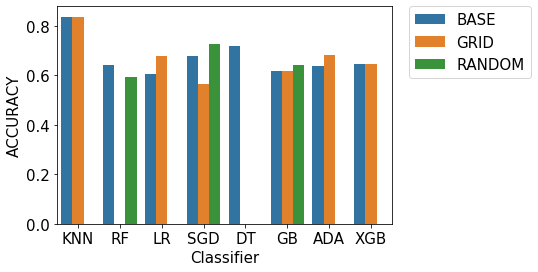

In [79]:
# comparitive results for all the models 

df_results = pd.DataFrame({'classifier':['KNN','KNN',
                                         'RF','RF',
                                         'LR','LR',
                                         'SGD','SGD','SGD',
                                         'DT',
                                         'GB','GB','GB',
                                        'ADA','ADA',
                                        'XGB','XGB'],
                           'data_set':['BASE', 'GRID',
                                       'BASE','RANDOM',
                                      'BASE','GRID',
                                         'BASE','RANDOM','GRID',
                                         'BASE',
                                         'BASE','RANDOM','GRID',
                                        'BASE','GRID',
                                        'BASE','GRID'],
                
                          'accuracy':[knn_base_results,grid_knn_results,
                                      base_rf_results,random_rf_results,
                                      base_lr_results,grid_lr_results,
                                      sgdc_base_results,sgdc_random_results,sgdc_grid_results,
                                      tree_base_results,
                                      gbc_base_results,gbc_random_results,gbc_grid_results,
                                      ada_base_results ,ada_grid_results,
                                      xgb_base_results,xgb_grid_results,]
                          })
# showcase results in form of table
df_results

#create a histogram of the output
ax = sns.barplot(x="classifier", y="accuracy", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('ACCURACY', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

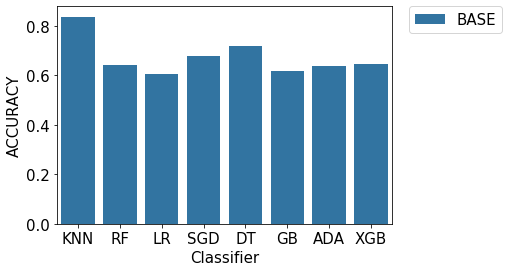

In [80]:
# compare base models 
df_results_base = pd.DataFrame({'classifier':['KNN',
                                         'RF',
                                         'LR',
                                         'SGD',
                                         'DT',
                                         'GB',
                                        'ADA',
                                        'XGB'],
                           'data_set':['BASE']*8,
                
                          'accuracy':[knn_base_results,
                                      base_rf_results,
                                      base_lr_results,
                                      sgdc_base_results,
                                      tree_base_results,
                                      gbc_base_results,
                                      ada_base_results ,
                                      xgb_base_results,]
                          })

# showcase results in form of table
df_results_base

#create a histogram of the output
ax = sns.barplot(x="classifier", y="accuracy", hue="data_set", data=df_results_base)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('ACCURACY', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

Text(0, 0.5, 'Mean Error')

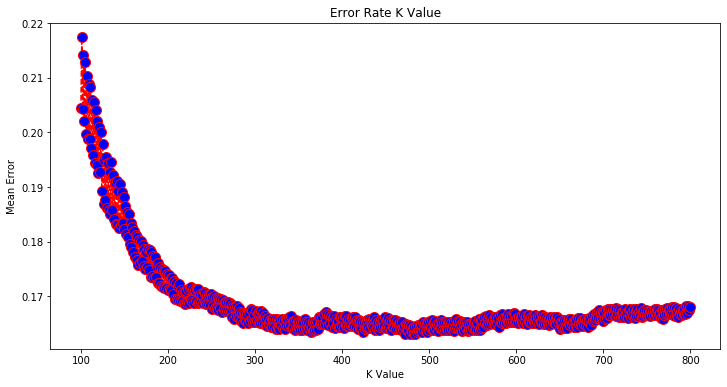

In [81]:
# calculate error in KNN algorithms
error = []

# Calculating error for K values between 1 and 40
for i in range(100, 800):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_tf, y_train_tf)
    pred_i = knn.predict(X_test_tf)
    error.append(np.mean(pred_i != y_test_tf))

    
#plot a diagram for mean error and K values
plt.figure(figsize=(12, 6))
plt.plot(range(100, 800), error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')